# Sovereign Default with Long-Term Debt - Solved with JAX


This notebook solves the Arellano (2008) model with long-term debt using Adaptive Sparse Grids

## Model Setup and Calibration

In [ ]:

import jax
import jax.numpy as jnp
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Use 64-bit precision for stability
jax.config.update("jax_enable_x64", True)

def print_jax_device_info():
    """Checks and prints the device JAX is using."""
    try:
        device = jax.devices()[0]
        device_type = device.device_kind.upper()
        print(f"✅ JAX is configured to run on: {device_type}")
    except Exception as e:
        print(f"An error occurred while checking JAX devices: {e}")

print_jax_device_info()


# ============================================================================ #
#                                 I. CALIBRATION                               #
# ============================================================================ #

# --- Model Parameters --- #
beta    = 0.953      # time discount rate
gamma   = 2.0       # risk aversion
r       = 0.017         # international interest rate
theta   = 0.282     # probability of regaining market access after default
ny      = 21           # number of points in y grid
nB      = 251          # number of points in B grid
delta   = 0.05      # debt maturity rate (0.05 = long-term, 1.0 = one-period)
damping = 1       # damping factor for bond price updates
vfi_tol = 1e-6      # tolerance for value function iteration
maxit   = 3000      # maximum number of iterations (JAX is fast)

# --- Taste Shock Parameters (Stable set) --- #
eta_d = 1e-4        # Taste shock for default choice
rho_b = 1e-4        # Taste shock for borrowing choice

# --- Calculated Parameters --- #
q_rf = 1 / (1 + r)
coupon = (r + delta) * q_rf

# --- Output Cost of Default --- #
d0 = -0.47
d1 = 0.6

print("\nModel parameters (with Taste Shocks for JAX):")
print(f"  β = {beta}, γ = {gamma}, r = {r}")
print(f"  η (default shock) = {eta_d}, ρ (borrowing shock) = {rho_b}")

# --- Grids and Income Process --- #
B_grid = jnp.linspace(0.0, 0.9, nB)
mc = qe.tauchen(ny, 0.945, 0.025, n_std=1.5)
Pi = jnp.array(mc.P)
y_grid = jnp.exp(mc.state_values)
y_def_grid = y_grid - jnp.maximum(0.0, d0*y_grid + d1*y_grid**2)


# ============================================================================ #


## JAX Core Functions with Gumbel Smoothing

In [2]:
#                           II. JAX HELPER FUNCTIONS                           #
# ============================================================================ #

@jax.jit
def u(c, gamma):
    return (jnp.maximum(c, 1e-14)**(1 - gamma)) / (1 - gamma)

@jax.jit
def logsumexp_jax(W_vec, rho):
    """ JAX implementation of numerically stable log-sum-exp """
    max_W = jnp.max(W_vec)
    W_adj = W_vec - max_W
    exp_term = jnp.exp(W_adj / rho)
    sum_exp = jnp.sum(exp_term)
    
    value = max_W + rho * jnp.log(sum_exp)
    probs = exp_term / sum_exp
    return value, probs

# Vmap to apply logsumexp over all (B, y) states efficiently
# It maps the function over the first two axes of a 3D W_tensor
vmapped_logsumexp = jax.vmap(logsumexp_jax, in_axes=(0, None), out_axes=(0, 0))
vmapped_logsumexp = jax.vmap(vmapped_logsumexp, in_axes=(1, None), out_axes=(1, 1))

@jax.jit
def compute_repayment_value(EVf, q):
    """ Computes the repayment value Vr and borrowing probabilities prob_b """
    # Create 3D grids for vectorization: [ib, iy, ibp]
    B_3d = B_grid[:, jnp.newaxis, jnp.newaxis]
    y_3d = y_grid[jnp.newaxis, :, jnp.newaxis]
    Bp_3d = B_grid[jnp.newaxis, jnp.newaxis, :]
    
    q_3d = q.T[jnp.newaxis, :, :]      # q(y, B')
    EVf_3d = EVf.T[jnp.newaxis, :, :]  # EVf(y, B')

    # Consumption for all (B, y, B') choices
    c = y_3d - B_3d * coupon + q_3d * Bp_3d - q_3d * (1 - delta) * B_3d
    
    # Value W for all choices, with penalty for negative consumption
    W_tensor = jnp.where(
        c > 0,
        u(c, gamma) + beta * EVf_3d,
        -jnp.inf
    )
    
    # Apply logsumexp across the B' dimension (axis=2) for all (B,y)
    Vr, prob_b_transposed = vmapped_logsumexp(W_tensor, rho_b)
    
    # Transpose prob_b to get shape (nB_prime', nB, ny)
    prob_b = prob_b_transposed.transpose((2, 0, 1))
    
    return Vr, prob_b

@jax.jit
def compute_bond_prices(prob_d, prob_b, q):
    """ Computes bond prices using vectorized operations """
    # E_B''[q(y', B'')] = sum_{B''} Pr(B''|B',y') * q(y',B'')
    # prob_b is (nB'', nB', ny'), q is (nB'', ny')
    # We want result of shape (nB', ny')
    expected_q_next = jnp.einsum('kji,ki->ji', prob_b, q)
    
    bond_payoff = coupon + (1 - delta) * expected_q_next
    prob_repay = 1.0 - prob_d
    
    # E_y'[ (1-prob_d) * payoff ]
    # The term (prob_repay * bond_payoff) has shape (nB, ny). We need to transpose
    # it to (ny, nB) for the matrix multiplication with Pi (ny, ny).
    expected_value = Pi @ (prob_repay * bond_payoff).T
    
    # This is q(y, B') which has shape (ny, nB'). We need (nB', ny).
    return expected_value.T / (1 + r)


## Value Function Iteration Loop

In [3]:

# ============================================================================ #
#                                III. VFI LOOP                                 #
# ============================================================================ #

def solve_jax(tol=vfi_tol, max_iter=maxit, damp=damping):
    """ Solves the model using JAX-optimized VFI """
    
    # Initialize value functions and prices
    Vf = jnp.zeros((nB, ny))
    Vd = jnp.zeros(ny)
    Vr = jnp.zeros((nB, ny))
    q = jnp.ones((nB, ny)) / (1 + r)
    
    # Pre-compute matrix for solving Vd
    A_vd = jnp.identity(ny) - beta * (1 - theta) * Pi
    u_def = u(y_def_grid, gamma)
    zero_ind = jnp.searchsorted(B_grid, 0.0)

    print("\nStarting JAX VFI...")
    print("="*70)
    
    start_time = time.time()
    loop = tqdm(range(max_iter))

    for it in loop:
        Vf_old, q_old = Vf, q
        
        # --- Core VFI Steps --- #
        EVf = Vf @ Pi.T
        Vr, prob_b = compute_repayment_value(EVf, q)
        
        b_vd = u_def + beta * theta * EVf[zero_ind, :]
        Vd = jnp.linalg.solve(A_vd, b_vd)
        
        # Numerically stable calculation for Vf and prob_d
        max_V = jnp.maximum(Vd, Vr)
        exp_Vd_scaled = jnp.exp((Vd - max_V) / eta_d)
        exp_Vr_scaled = jnp.exp((Vr - max_V) / eta_d)
        Vf = max_V + eta_d * jnp.log(exp_Vd_scaled + exp_Vr_scaled)
        prob_d = exp_Vd_scaled / (exp_Vd_scaled + exp_Vr_scaled)
        
        q_new = compute_bond_prices(prob_d, prob_b, q)
        q = (1 - damp) * q_old + damp * q_new
        
        # --- Check Convergence --- #
        dist_v = jnp.max(jnp.abs(Vf_old - Vf))
        dist_q = jnp.max(jnp.abs(q_old - q))
        jax.block_until_ready(dist_v) # Ensure computation is finished
        
        if it % 10 == 0:
            loop.set_postfix(dist_v=f"{dist_v:.2e}", dist_q=f"{dist_q:.2e}")
        
        if dist_v < tol and dist_q < tol:
            elapsed = time.time() - start_time
            print("\n" + "="*70)
            print(f"✓ Converged at iteration {it} in {elapsed:.2f}s")
            print(f"  dist_v = {dist_v:.8f}, dist_q = {dist_q:.8f}")
            print("="*70)
            break
            
    return Vf, Vd, Vr, q, prob_b, prob_d


## Visualization and Results


Starting JAX VFI...


 12%|█▏        | 360/3000 [00:05<00:37, 69.81it/s, dist_q=9.96e-07, dist_v=2.81e-08] 



✓ Converged at iteration 360 in 5.16s
  dist_v = 0.00000003, dist_q = 0.00000100
Plotting results...

✓ Figure saved as 'Arellano_TasteShocks_JAX_Results.png'


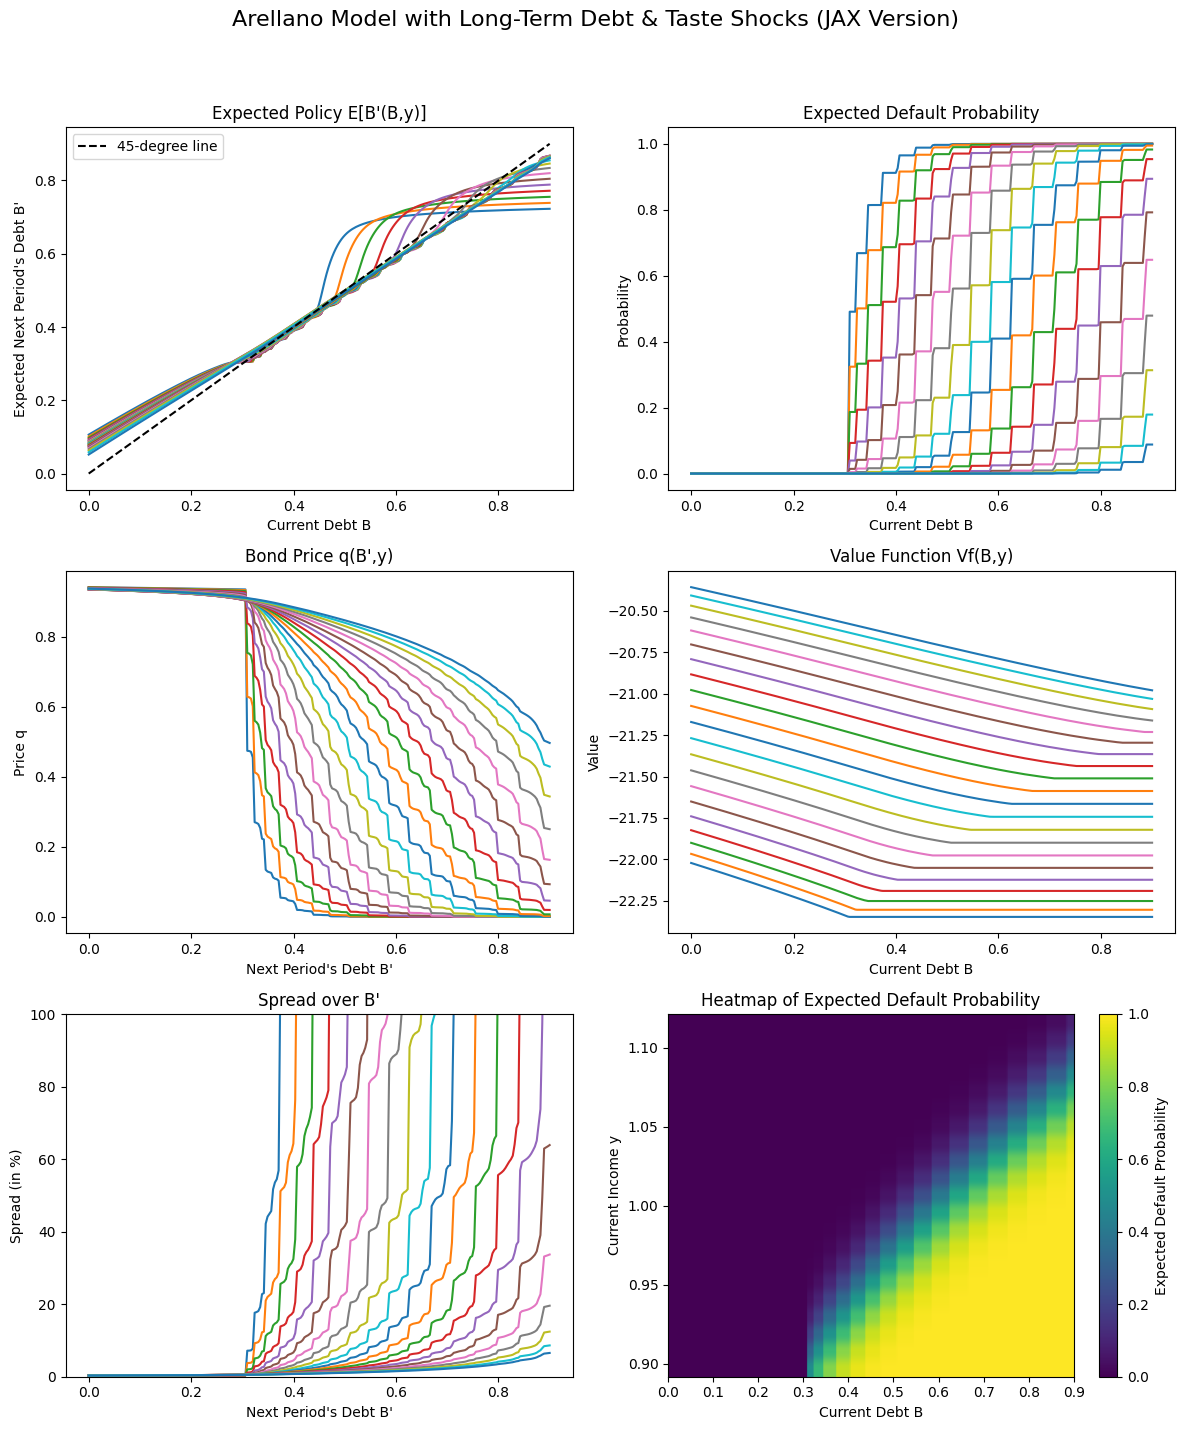

In [4]:

# --- Call the solver --- #
Vf, Vd, Vr, q, prob_b, prob_d = solve_jax()


# ============================================================================ #
#                              IV. VISUALIZE RESULTS                           #
# ============================================================================ #
print("Plotting results...")

# --- Convert JAX arrays to NumPy for plotting ---
Vf, q, prob_b, prob_d = np.array(Vf), np.array(q), np.array(prob_b), np.array(prob_d)
B_grid_np, Pi_np, y_grid_np = np.array(B_grid), np.array(Pi), np.array(y_grid)

# --- Compute final quantities for plotting ---
spread = (coupon / np.maximum(q, 1e-9) - delta) - r
spread[spread < 0] = 0

# Calculate Expected B' policy
E_B_prime = np.zeros((nB, ny))
for iy in range(ny):
    for ib in range(nB):
        # prob_b has shape (nB_prime', nB, ny)
        E_B_prime[ib, iy] = np.sum(prob_b[:, ib, iy] * B_grid_np)

# Calculate expected default probability for the next period
# The correct calculation is prob_d @ Pi.T, to sum over next period's states
defprob_exp = prob_d @ Pi_np.T

# --- Create 3x2 plot grid ---
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("Arellano Model with Long-Term Debt & Taste Shocks (JAX Version)", fontsize=16)

# Plot 1: Policy E[B'(B,y)]
ax = axes[0, 0]
ax.plot(B_grid_np, E_B_prime)
ax.plot(B_grid_np, B_grid_np, 'k--', label='45-degree line')
ax.set_title("Expected Policy E[B'(B,y)]")
ax.set_xlabel("Current Debt B"); ax.set_ylabel("Expected Next Period's Debt B'")
ax.legend()

# Plot 2: Expected Default Probability p(B,y)
ax = axes[0, 1]
ax.plot(B_grid_np, defprob_exp)
ax.set_title("Expected Default Probability")
ax.set_xlabel("Current Debt B"); ax.set_ylabel("Probability")

# Plot 3: Bond Price q(B',y)
ax = axes[1, 0]
ax.plot(B_grid_np, q)
ax.set_title("Bond Price q(B',y)")
ax.set_xlabel("Next Period's Debt B'"); ax.set_ylabel("Price q")

# Plot 4: Value Function Vf(B,y)
ax = axes[1, 1]
ax.plot(B_grid_np, Vf)
ax.set_title("Value Function Vf(B,y)")
ax.set_xlabel("Current Debt B"); ax.set_ylabel("Value")

# Plot 5: Spread over B'
ax = axes[2, 0]
ax.plot(B_grid_np, spread * 100)
ax.set_title("Spread over B'")
ax.set_xlabel("Next Period's Debt B'"); ax.set_ylabel("Spread (in %)")
ax.set_ylim(0, 100)

# Plot 6: Heatmap of Expected Default Probability
ax = axes[2, 1]
# Plot transpose of defprob_exp and swap extent/labels to flip axes
im = ax.imshow(defprob_exp.T,
               origin='lower',
               aspect='auto',
               extent=[B_grid_np[0], B_grid_np[-1], y_grid_np[0], y_grid_np[-1]],
               cmap='viridis')
fig.colorbar(im, ax=ax, label='Expected Default Probability')
ax.set_title("Heatmap of Expected Default Probability")
ax.set_xlabel("Current Debt B")
ax.set_ylabel("Current Income y")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("Arellano_TasteShocks_JAX_Results.png")
print("\n✓ Figure saved as 'Arellano_TasteShocks_JAX_Results.png'")
plt.show()
